### Imports

In [114]:
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import nn, vmap, lax, jit
from jax import random as jr
import numpy as np
from jax.scipy.linalg import expm
from scipy.linalg import logm

from pymdp.jax.task import PyMDPEnv
from pymdp.jax.agent import Agent as AIFAgent

import matplotlib.pyplot as plt
import seaborn as sns

key = jr.PRNGKey(987)

### Hidden semi-Markov models

We will make a semi-markov environmnet where sates depend on latent phase variable, which specifies if a state can be changed or not. 

In [ ]:
num_states = 5
num_phases = 10
num_contexts = 10

B_context = jnp.eye(num_contexts)

B_state = jnp.diag(jnp.ones(num_states - 1), k=1) + nn.one_hot(num_states - 1, num_states)[:, None] * nn.one_hot(0, num_states)[None]
B_state

key, _key = jr.split(key)
B_perm = jr.permutation(_key, B_state, axis=0)
B_perm

rho = jnp.expand_dims(1/ jnp.arange(1, 100), (0, 1))
end_transition = nn.one_hot(0, num_phases + 1)[:, None] * nn.one_hot(num_phases, num_phases + 1)[None]
G_phases = (1 - rho) * jnp.eye(num_phases + 1)[..., None] + rho * jnp.diag(jnp.ones(num_phases), k=-1)[..., None] + end_transition[..., None]

expm( G_phases[..., 0] )

In [109]:
def gen_matrix(n):
    delta = 1 / jnp.arange(1, n+1)[::-1]
    H = jnp.diag( jnp.pad(-delta, (0, 1)) ) + jnp.diag(delta, k=1)
    return H.mT

Q = gen_matrix(4)

P = expm(Q)
pi = nn.one_hot(0, 5)
P = P.at[:, -1].set(pi)

P @ nn.one_hot(0, 5)


Array([9.7530997e-01, 2.4281437e-02, 4.0189430e-04, 6.5925701e-06,
       1.6654124e-07], dtype=float32)

In [121]:
TT = B_state.mT.at[:, -1].set( nn.one_hot(4, 5) )

logm( TT )

logm result may be inaccurate, approximate err = 2.637218354519009e+48


/home/dima/.conda/envs/pymdp/lib/python3.11/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


array([[-4.60517006e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000002e+20, -4.60517006e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.00000032e+39,  1.00000002e+20, -4.60517006e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 3.33333365e+59, -5.00000032e+39,  1.00000002e+20,
        -4.60517006e+01,  0.00000000e+00],
       [-3.33333365e+59,  5.00000032e+39, -1.00000003e+20,
         4.60517006e+01,  0.00000000e+00]])

In [116]:
logm( B_state.mT ).real

logm result may be inaccurate, approximate err = 1.3862793791211766e-06


array([[-1.48835798e-07, -1.06895915e+00,  6.60653370e-01,
        -6.60653078e-01,  1.06895919e+00],
       [ 1.06895980e+00,  3.46117048e-08, -1.06895919e+00,
         6.60652596e-01, -6.60653290e-01],
       [-6.60653819e-01,  1.06895945e+00, -4.84383250e-08,
        -1.06895978e+00,  6.60653568e-01],
       [ 6.60653355e-01, -6.60652852e-01,  1.06895972e+00,
         4.14467701e-07, -1.06895980e+00],
       [-1.06895950e+00,  6.60652566e-01, -6.60653187e-01,
         1.06895984e+00,  5.32773044e-07]])

In [22]:
num_rows, num_columns = 7, 7
num_states = [num_rows * num_columns] # number of states equals the number of grid locations
num_obs = [num_rows * num_columns]    # number of observations equals the number of grid locations (fully observable)

# number of agents
n_batches = 20

# construct A arrays
# fully observable (identity observation matrix)
A = [jnp.broadcast_to(jnp.eye(num_states[0]), (n_batches,) + (num_obs[0], num_states[0]))] 

# construct B arrays
grid_world = GridWorldEnv(shape=[num_rows, num_columns])
# easy way to get the generative model parameters is to extract them from one of pre-made GridWorldEnv classes
B = [jnp.broadcast_to(jnp.array(grid_world.get_transition_dist()), (n_batches,) + (num_states[0], num_states[0], grid_world.n_control))]  
num_controls = [grid_world.n_control] # number of control states equals the number of actions
 
# create mapping from gridworld coordinates to linearly-index states
states = np.arange(grid_world.n_states)
coords = np.unravel_index(states, (num_rows, num_columns) )
coord_to_idx_map = {(i, j): s for i, j, s in zip(coords[0], coords[1], states)}

# construct C arrays
# desired_position = (0, 0) # lower corner
# desired_state_id = coord_to_idx_map[desired_position]
# desired_obs_id = jnp.argmax(A[0][:, desired_state_id]) # throw this in there, in case there is some indeterminism between states and observations
# C = [jnp.broadcast_to(nn.one_hot(desired_obs_id, num_obs[0]), (n_batches, num_obs[0]))]

# construct D arrays
starting_position = (3, 3) # upper left corner
starting_state_id = coord_to_idx_map[starting_position]
starting_obs_id = jnp.argmax(A[0][:, starting_state_id]) # throw this in there, in case there is some indeterminism between states and observations
D = [jnp.broadcast_to(nn.one_hot(starting_state_id, num_states[0]), (n_batches, num_states[0]))]

params = {
    'A': A,
    'B': B,
    'D': D
}

dependencies = {
    'A': [[0]],
    'B': [[0]]
}

grid_world = PyMDPEnv(params, dependencies=dependencies)

NameError: name 'GridWorldEnv' is not defined

In [3]:
# Define KL divergence between Dirichlet distributions
from jax.scipy.special import gammaln, digamma

@jit
def kl_div_dirichelt(alpha1, alpha2):
    alpha0 = alpha1.sum(1, keepdims=True)
    kl = gammaln(alpha0.squeeze(1)) - gammaln(alpha2.sum(1))
    kl += jnp.sum(gammaln(alpha2) - gammaln(alpha1) + (alpha1 - alpha2) * (digamma(alpha1) - digamma(alpha0)), 1)

    return kl

# Define the rollout function
def rollout(rng_key, agent, env, num_timesteps):
    """
    Rollout an agent in an environment for a number of timesteps.

    Parameters
    ----------
    agent: ``Agent``
        Agent to interact with the environment
    env: ``PyMDPEnv`
        Environment to interact with
    num_timesteps: ``int``
        Number of timesteps to rollout for
    rng_key: ``PRNGKey``
        Random key to use for sampling actions

    Returns
    ----------
    last: ``dict``
        Carry dictionary from the last timestep
    info: ``dict``
        Dictionary containing information about the rollout, i.e. executed actions, observations, beliefs, etc.
    env: ``PyMDPEnv``
        Environment state after the rollout
    """
    # get the batch_size of the agent
    batch_size = agent.batch_size

    def step_fn(carry, x):
        action_t = carry["action_t"]
        observation_t = jtu.tree_map(lambda x: jnp.expand_dims(x, -1), carry["observation_t"])
        empirical_prior = carry["empirical_prior"]
        env = carry["env"]
        states = env.states[0]
        rng_key = carry["rng_key"]

        qs = agent.infer_states(
            observation_t,
            empirical_prior
        )
        qpi, nefe = agent.infer_policies(qs)

        keys = jr.split(rng_key, batch_size + 1)
        rng_key = keys[0]
        new_action = agent.sample_action(qpi, rng_key=keys[1:])

        keys = jr.split(rng_key, batch_size + 1)
        rng_key = keys[0]
        observation_t, env = env.step(keys[1:], actions=new_action)

        empirical_prior, qs = agent.update_empirical_prior(new_action, qs)

        carry = {
            "action_t": new_action,
            "observation_t": observation_t,
            "empirical_prior": empirical_prior,
            "env": env,
            "rng_key": rng_key,
        }
        info = {
            "qpi": qpi,
            "qs": jtu.tree_map(lambda x: x[:, 0, ...], qs),
            "states": states,
            "observations": observation_t,
            "actions": action_t,
        }

        return carry, info

    # generate initial observation
    keys = jr.split(rng_key, batch_size + 1)
    states_0 = env.states[0]
    observation_0, env = env.step(keys[1:])

    initial_carry = {
        "action_t": None,
        "observation_t": observation_0,
        "empirical_prior": agent.D,
        "env": env,
        "rng_key": keys[0],
    }

    carry1, info1 = step_fn(initial_carry, None)

    # Scan over time dimension (axis 1)
    last, info = lax.scan(step_fn, carry1, jnp.arange(num_timesteps))

    init_obs = jtu.tree_map(lambda x, y: jnp.stack([x, y], -1), observation_0, carry1['observation_t'])

    info = jtu.tree_map(lambda x: jnp.swapaxes(x, 0, 1), info)
    info['qs'] = jtu.tree_map( lambda x, y: jnp.concatenate([jnp.expand_dims(x, 1), y], 1), info1['qs'], info['qs'])
    info['observations'] = jtu.tree_map(lambda x, y: jnp.concatenate([x, y[:, :-1]], 1), init_obs, info['observations'])
    info['states'] = jtu.tree_map(lambda x, y: jnp.concatenate([jnp.expand_dims(x, 1), y], 1), states_0, info['states'])

    return last, info

### Initialize different agents using `Agent()` class

In [4]:
# create agent with A matrix being fixed to the A of the generative process
C = [jnp.zeros((n_batches, num_obs[0]))]
pB = [jnp.ones_like(B[0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)
_D = [jnp.ones((n_batches, num_states[0]))]

agents = []
for i in range(5):
    agents.append( 
        AIFAgent(
            A,
            _B,
            C,
            _D,
            E=None,
            pA=None,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(1),
            alpha=jnp.ones(1) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=False,
            learn_B=True,
            learn_D=True,
        )
    )

### Run active inference

In [5]:
pB0 = 1e4 * B[0] + 1e-4
num_timesteps = 50
num_blocks = 40
key = jr.PRNGKey(0)
divs = {i : [] for i in range(len(agents))}
for block in range(num_blocks):
    for i, agent in enumerate(agents):
        key, _key = jr.split(key)
        grid_world = grid_world.reset(_key)

        key, _key = jr.split(key)
        last, info = jit(rollout, static_argnums=[3,] )(_key, agent, grid_world, num_timesteps)
        grid_world = last['env']

        beliefs = info['qs']
        actions = info['actions']
        outcomes = info['observations']

        agents[i] = agent.infer_parameters(beliefs, outcomes, actions)
        divs[i].append(kl_div_dirichelt(agents[i].pB[0], pB0).sum(-1).mean(-1))

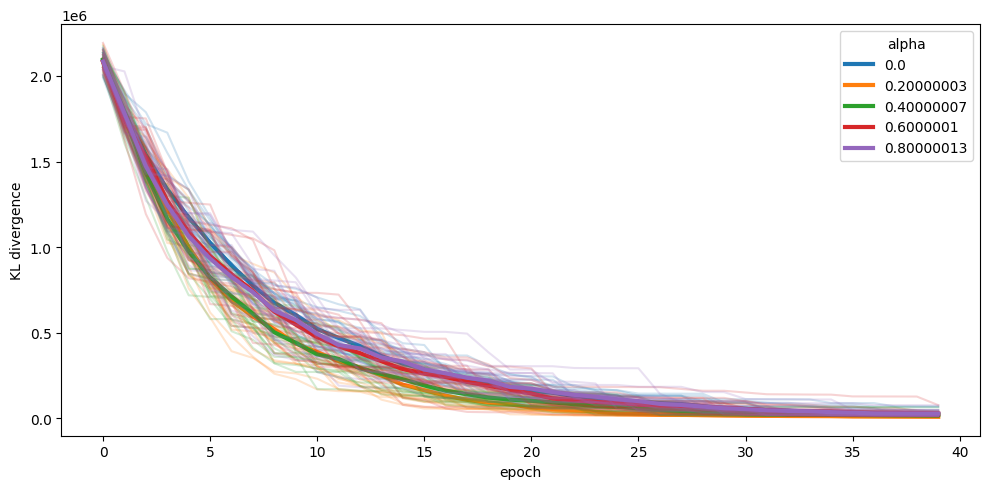

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

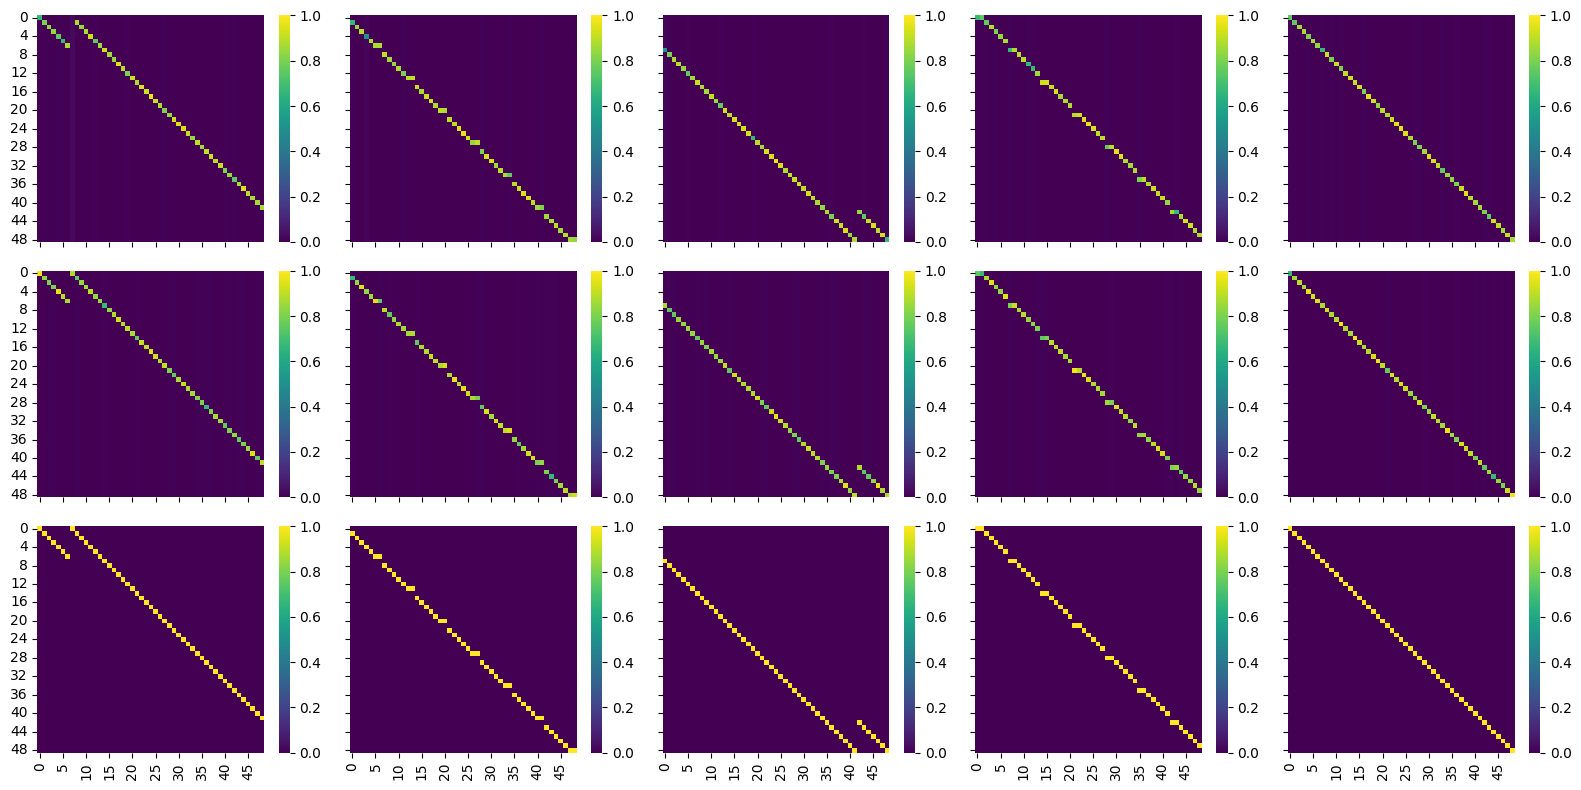

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)

for i in range(num_controls[0]):
    for j, agent in enumerate(agents[:2]):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(B[0][0, ..., i], ax=axes[2, i], cmap='viridis', vmax=1., vmin=0.)

fig.tight_layout()

In [8]:
# create agent with B matrix being fixed to the B of the generative process
C = [jnp.zeros((n_batches, num_obs[0]))]
pA = [jnp.ones_like(A[0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)

agents = []
for i in range(5):
    agents.append( 
        AIFAgent(
            _A,
            B,
            C,
            D,
            E=None,
            pA=pA,
            pB=None,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(1),
            alpha=jnp.ones(1) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
        )
    )

In [9]:
from pymdp.jax.inference import smoothing_ovf

key, _key = jr.split(key)
grid_world = grid_world.reset(_key)

key, _key = jr.split(key)
last, info = jit(rollout, static_argnums=[3,] )(_key, agents[0], grid_world, num_timesteps)

beliefs = info['qs']
actions = info['actions']
smoothed_marginals_and_joints = vmap(smoothing_ovf)(beliefs, agents[0].B, actions)

In [10]:
pA0 = 1e4 * A[0] + 1e-4
num_timesteps = 50
num_blocks = 20
key = jr.PRNGKey(0)
divs = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    for i, agent in enumerate(agents):
        key, _key = jr.split(key)
        grid_world = grid_world.reset(_key)

        key, _key = jr.split(key)
        last, info = jit(rollout, static_argnums=[3,] )(_key, agent, grid_world, num_timesteps)
        grid_world = last['env']

        beliefs = info['qs']
        actions = info['actions']
        outcomes = info['observations']

        agents[i] = agent.infer_parameters(beliefs, outcomes, actions)
        divs[i].append(kl_div_dirichelt(agents[i].pA[0], pA0).mean(-1))

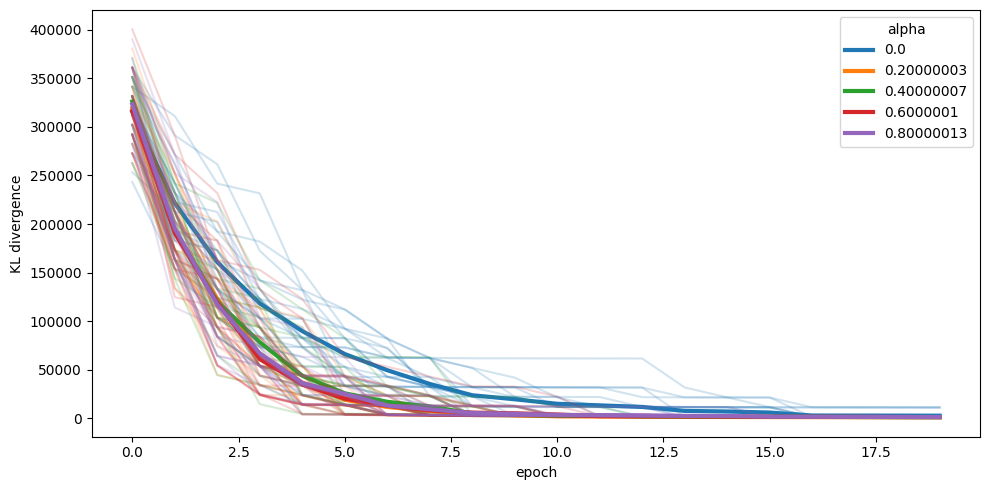

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

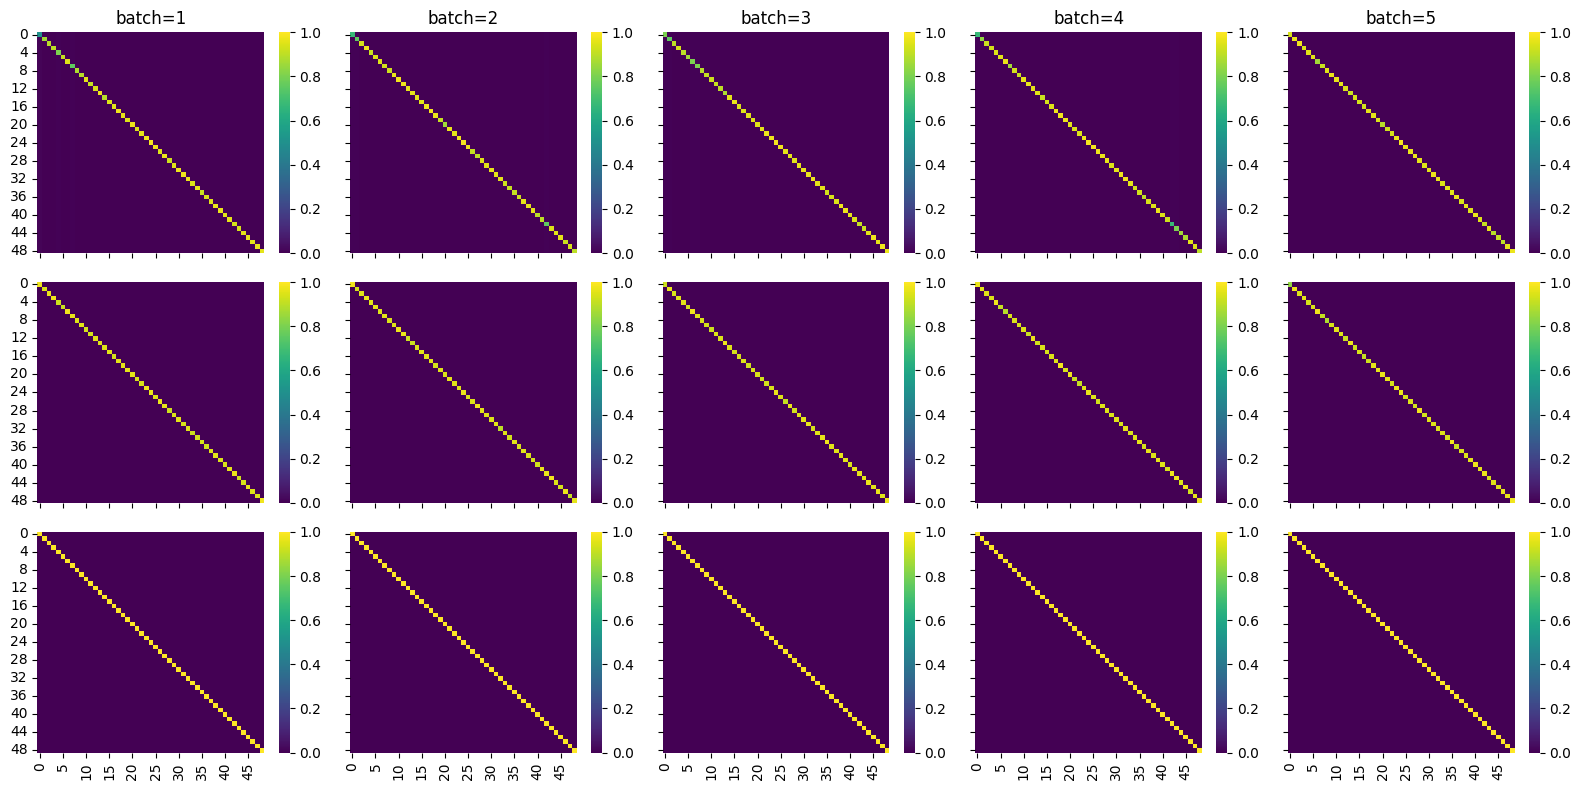

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)

for i in range(5):
    for j, agent in enumerate(agents[:2]):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(A[0][i], ax=axes[2, i], cmap='viridis', vmax=1., vmin=0.)

    axes[0, i].set_title(f'batch={i+1}')

fig.tight_layout()

In [13]:
# create agent with B matrix being fixed to the B of the generative process but flat beliefs over initial states
C = [jnp.zeros((n_batches, num_obs[0]))]
pA = [jnp.ones_like(A[0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)

agents = []
for i in range(5):
    agents.append( 
        AIFAgent(
            _A,
            B,
            C,
            _D,
            E=None,
            pA=pA,
            pB=None,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(1),
            alpha=jnp.ones(1) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
        )
    )

In [14]:
pA0 = 1e4 * A[0] + 1e-4
num_timesteps = 50
num_blocks = 20
key = jr.PRNGKey(0)
divs = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    for i, agent in enumerate(agents):
        key, _key = jr.split(key)
        grid_world = grid_world.reset(_key)

        key, _key = jr.split(key)
        last, info = jit(rollout, static_argnums=[3,] )(_key, agent, grid_world, num_timesteps)
        grid_world = last['env']

        beliefs = info['qs']
        actions = info['actions']
        outcomes = info['observations']

        agents[i] = agent.infer_parameters(beliefs, outcomes, actions)
        divs[i].append(kl_div_dirichelt(agents[i].pA[0], pA0).mean(-1))

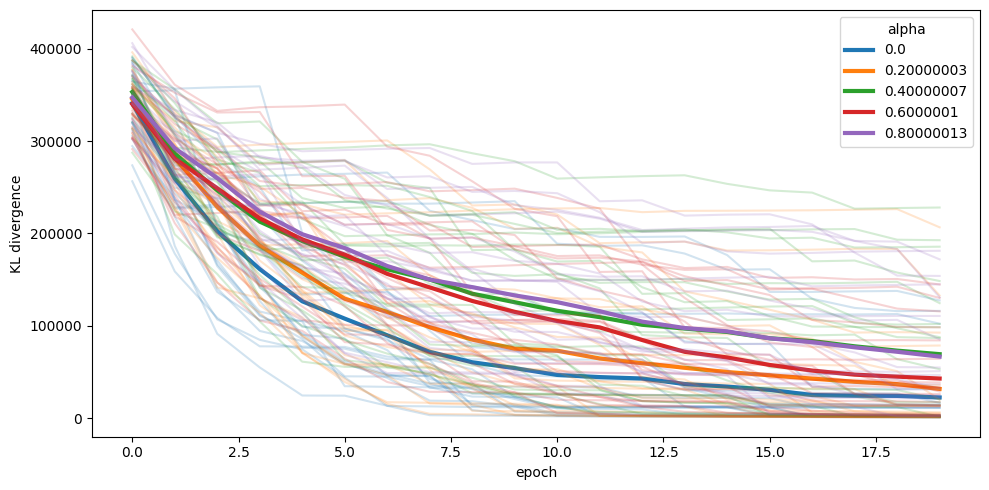

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
for i in range(len(agents)):
    p = axes.plot(jnp.stack(divs[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes.plot(jnp.stack(divs[i]), color=p[0].get_color(), alpha=.2)

axes.legend(title='alpha')
axes.set_ylabel('KL divergence')
axes.set_xlabel('epoch')
fig.tight_layout()

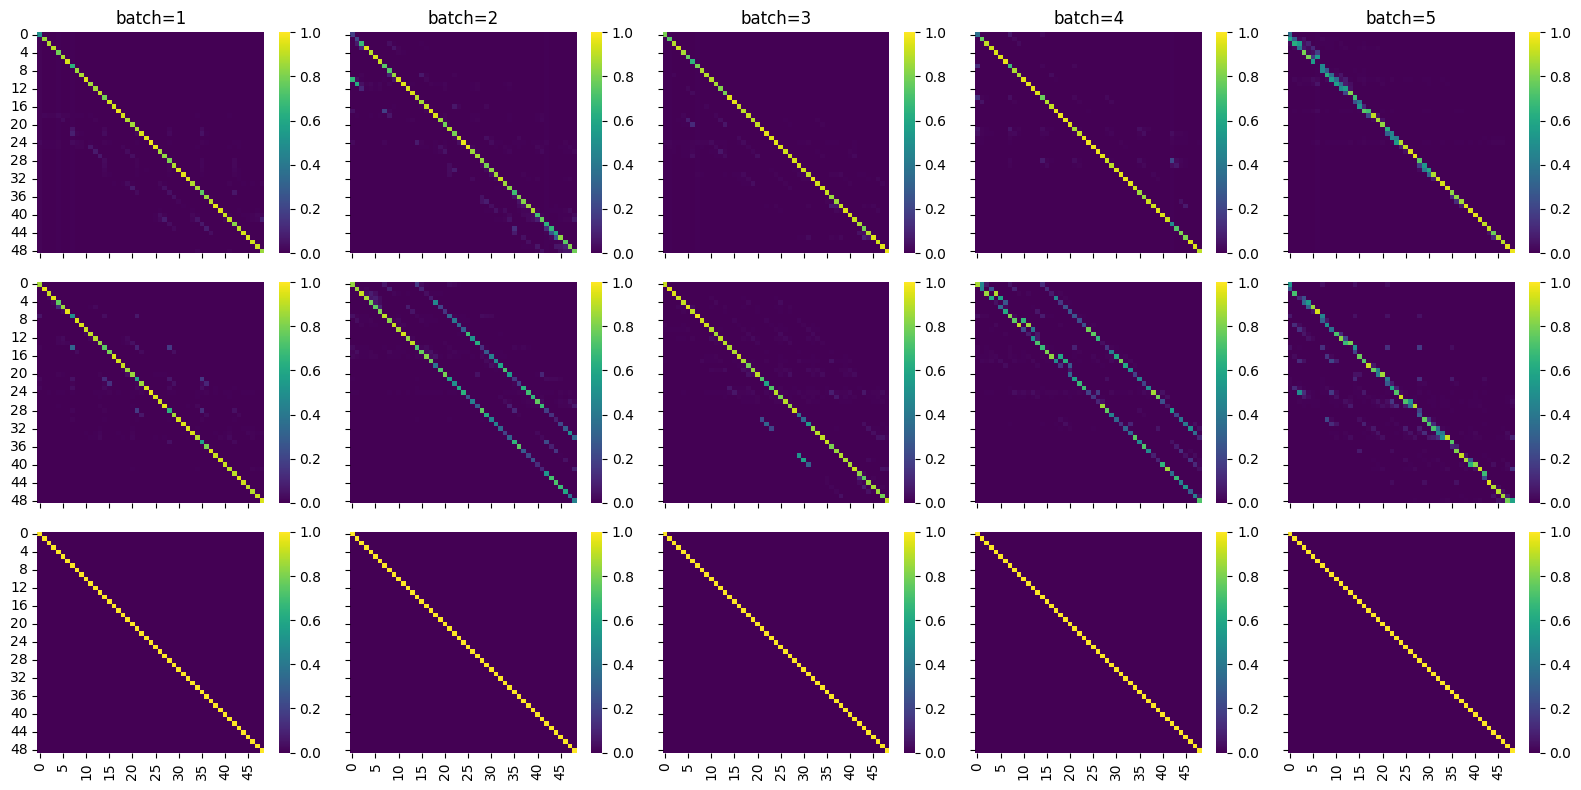

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)

for i in range(5):
    for j, agent in enumerate(agents[:2]):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(A[0][i], ax=axes[2, i], cmap='viridis', vmax=1., vmin=0.)

    axes[0, i].set_title(f'batch={i+1}')

fig.tight_layout()

In [28]:
# create agent with B matrix being fixed to the B of the generative process but flat beliefs over initial states
C = [jnp.zeros((n_batches, num_obs[0]))]
pA = [jnp.ones_like(A[0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
pB = [jnp.ones_like(B[0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)

agents = []
for i in range(5):
    agents.append( 
        AIFAgent(
            _A,
            _B,
            C,
            D,
            E=None,
            pA=pA,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(1),
            alpha=jnp.ones(1) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
        )
    )

In [29]:
pA0 = 1e4 * A[0] + 1e-4
pB0 = 1e4 * B[0] + 1e-4
num_timesteps = 50
num_blocks = 100
key = jr.PRNGKey(0)
divs1 = {i: [] for i in range(len(agents))}
divs2 = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    for i, agent in enumerate(agents):
        key, _key = jr.split(key)
        grid_world = grid_world.reset(_key)

        key, _key = jr.split(key)
        last, info = jit(rollout, static_argnums=[3,] )(_key, agent, grid_world, num_timesteps)
        grid_world = last['env']

        beliefs = info['qs']
        actions = info['actions']
        outcomes = info['observations']

        agents[i] = agent.infer_parameters(beliefs, outcomes, actions)
        divs1[i].append(kl_div_dirichelt(agents[i].pA[0], pA0).mean(-1))
        divs2[i].append(kl_div_dirichelt(agents[i].pB[0], pB0).sum(-1).mean(-1))

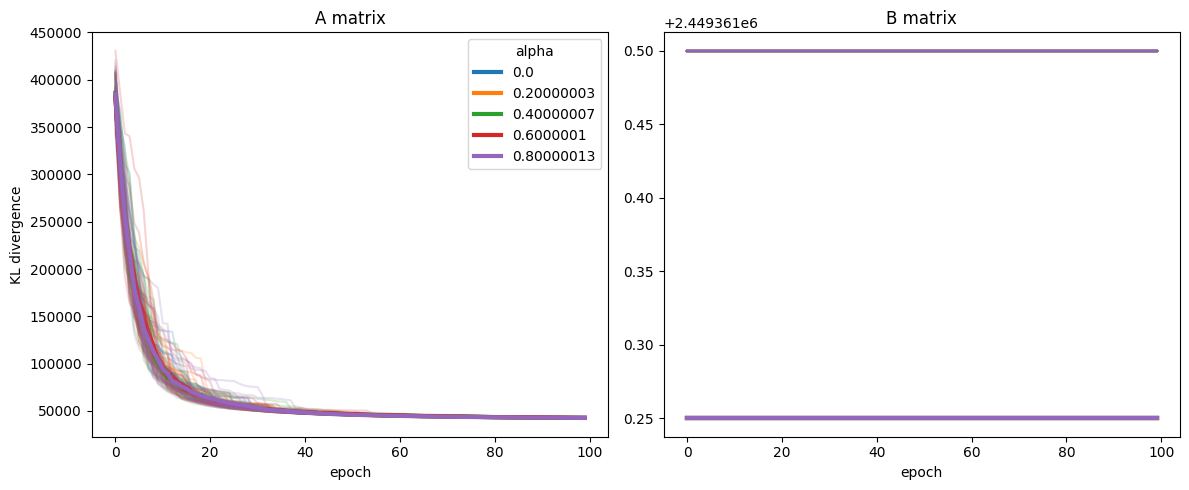

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)
for i in range(len(agents)):
    p = axes[0].plot(jnp.stack(divs1[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[0].plot(jnp.stack(divs1[i]), color=p[0].get_color(), alpha=.2)

    p = axes[1].plot(jnp.stack(divs2[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[1].plot(jnp.stack(divs2[i]), color=p[0].get_color(), alpha=.2)

axes[0].legend(title='alpha')
axes[0].set_ylabel('KL divergence')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_title('A matrix')
axes[1].set_title('B matrix')
fig.tight_layout()

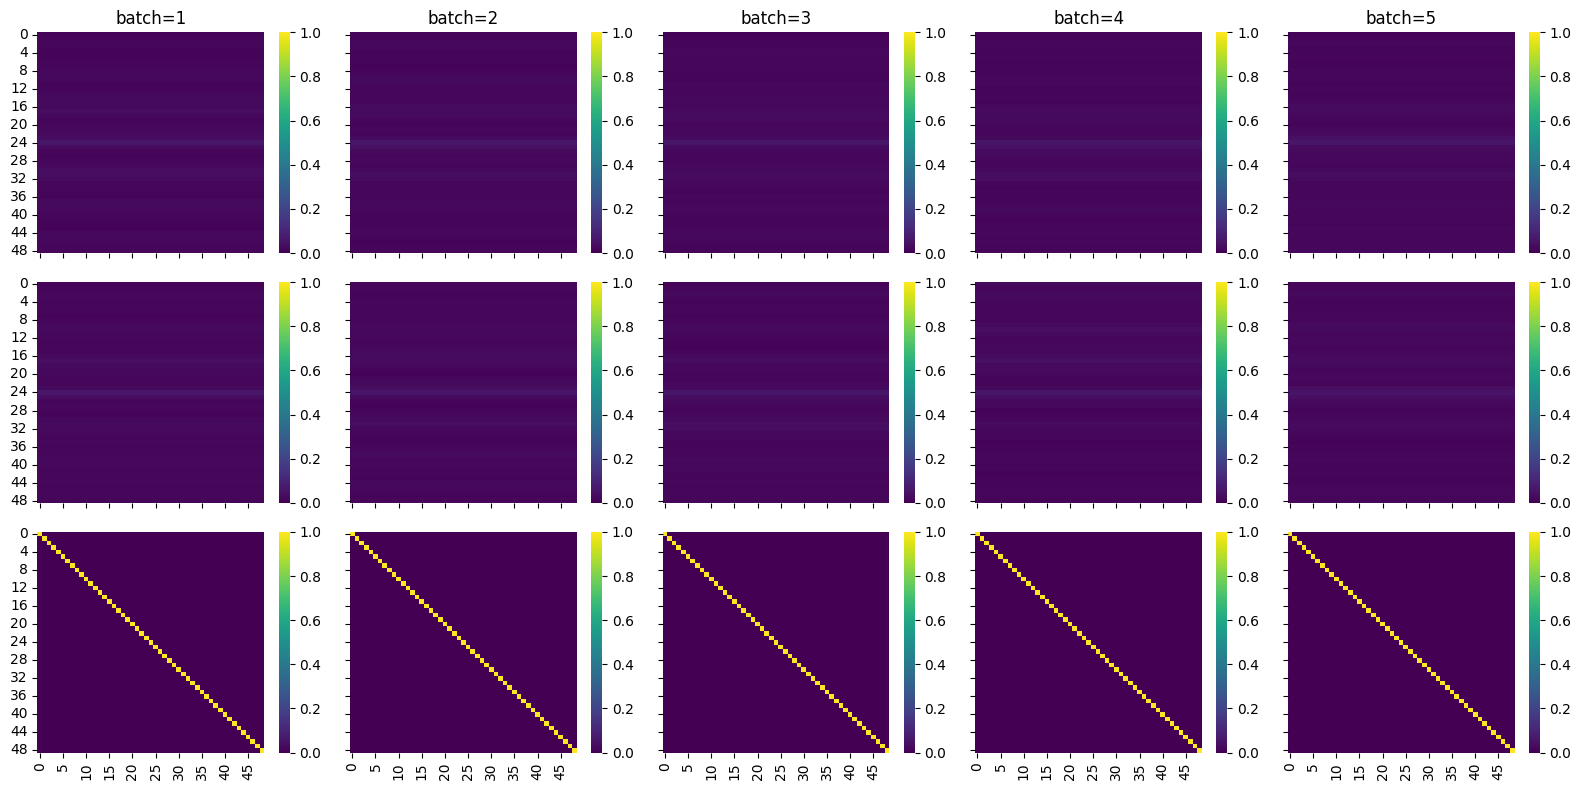

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)

for i in range(5):
    for j, agent in enumerate(agents[:2]):
        sns.heatmap(agent.A[0][i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(A[0][i], ax=axes[2, i], cmap='viridis', vmax=1., vmin=0.)

    axes[0, i].set_title(f'batch={i+1}')

fig.tight_layout()

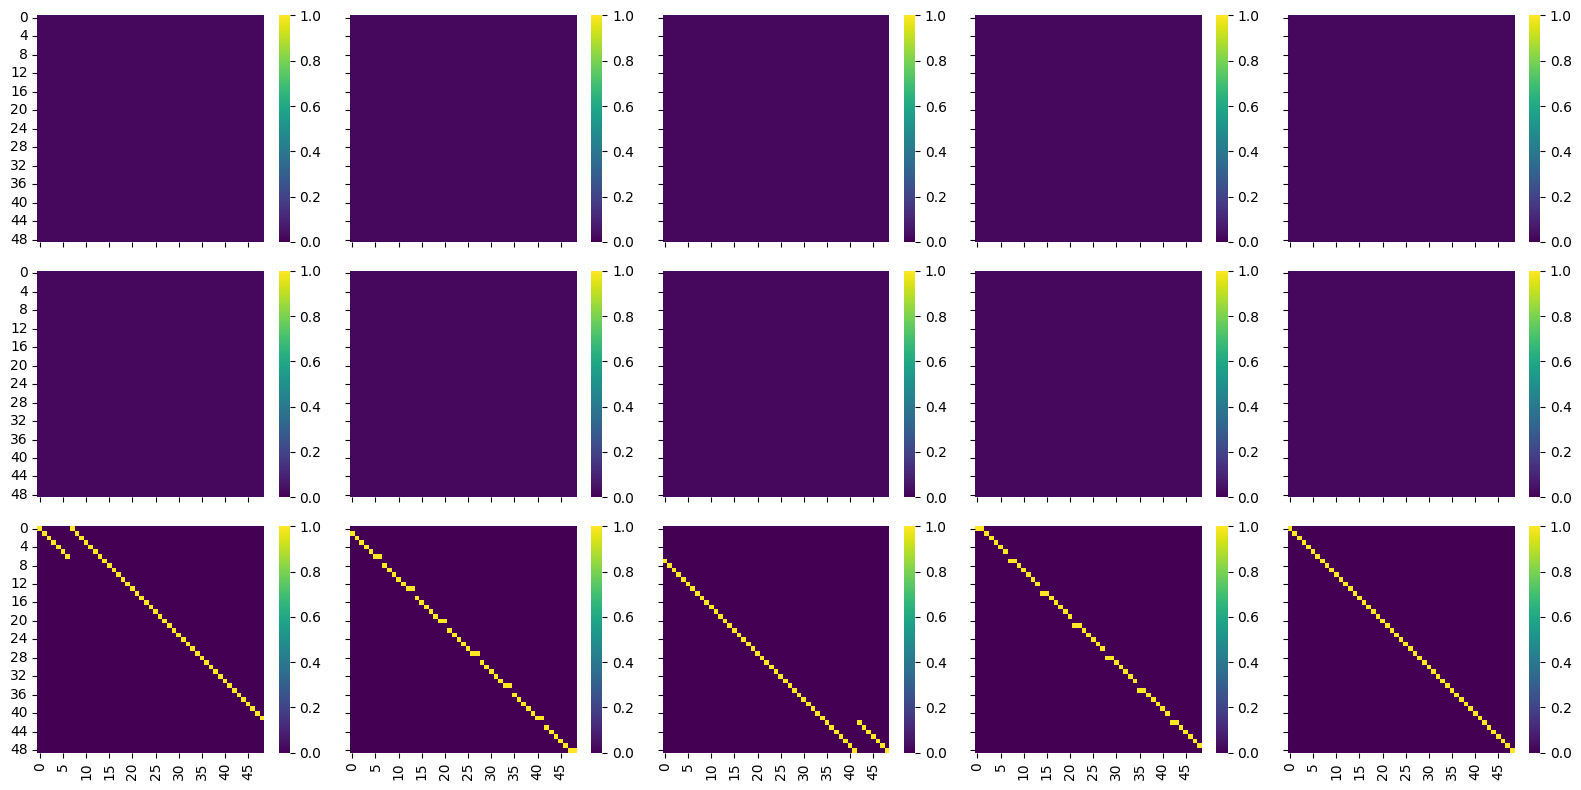

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)

for i in range(num_controls[0]):
    for j, agent in enumerate(agents[:2]):
        sns.heatmap(agent.B[0][0, ..., i], ax=axes[j, i], cmap='viridis', vmax=1., vmin=0.)
    sns.heatmap(B[0][0, ..., i], ax=axes[2, i], cmap='viridis', vmax=1., vmin=0.)
    axes[0, i].set_title(f'action {i+1}')

fig.tight_layout()

In [26]:
# create agent with B matrix being fixed to the B of the generative process but flat beliefs over initial states
C = [jnp.zeros((n_batches, num_obs[0]))]
pA = [jnp.ones_like(A[0]) / num_obs[0]]
_A = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pA)
tmpB = jnp.clip(B[0].sum(-1), max=1)
pB = [jnp.expand_dims(tmpB, -1) + jnp.ones_like(B[0]) / num_states[0]]
_B = jtu.tree_map(lambda x: x / x.sum(1, keepdims=True), pB)

agents = []
for i in range(5):
    agents.append( 
        AIFAgent(
            _A,
            _B,
            C,
            _D,
            E=None,
            pA=pA,
            pB=pB,
            policy_len=3,
            use_utility=False,
            use_states_info_gain=True,
            use_param_info_gain=True,
            gamma=jnp.ones(1),
            alpha=jnp.ones(1) * i * .2,
            onehot_obs=False,
            action_selection="stochastic",
            inference_algo="ovf",
            num_iter=1,
            learn_A=True,
            learn_B=False,
            learn_D=False,
        )
    )

In [27]:
pA0 = 1e4 * A[0] + 1e-4
pB0 = 1e4 * B[0] + 1e-4
num_timesteps = 50
num_blocks = 100
key = jr.PRNGKey(0)
divs1 = {i: [] for i in range(len(agents))}
divs2 = {i: [] for i in range(len(agents))}
for block in range(num_blocks):
    for i, agent in enumerate(agents):
        key, _key = jr.split(key)
        grid_world = grid_world.reset(_key)

        key, _key = jr.split(key)
        last, info = jit(rollout, static_argnums=[3,] )(_key, agent, grid_world, num_timesteps)
        grid_world = last['env']

        beliefs = info['qs']
        actions = info['actions']
        outcomes = info['observations']

        agents[i] = agent.infer_parameters(beliefs, outcomes, actions)
        divs1[i].append(kl_div_dirichelt(agents[i].pA[0], pA0).mean(-1))
        divs2[i].append(kl_div_dirichelt(agents[i].pB[0], pB0).sum(-1).mean(-1))

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)
for i in range(len(agents)):
    p = axes[0].plot(jnp.stack(divs1[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[0].plot(jnp.stack(divs1[i]), color=p[0].get_color(), alpha=.2)

    p = axes[1].plot(jnp.stack(divs2[i]).mean(-1), lw=3, label=agents[i].alpha.mean())
    axes[1].plot(jnp.stack(divs2[i]), color=p[0].get_color(), alpha=.2)

axes[0].legend(title='alpha')
axes[0].set_ylabel('KL divergence')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_title('A matrix')
axes[1].set_title('B matrix')
fig.tight_layout()